# **3. Datasets & DataLoaders**

데이터 샘플을 처리하는 코드는 지저분하기도 하고 유지보수를 어렵게 할 수도있어서 보통 모델 학습코드와 분리해서 작성하는게 바람직함

그래서 PyTorch는 두 가지 데이터 기본 구조를 제공함
1. torch.utils.data.Dataset : 데이터 샘플과 정답을 저장하는 클래스
2. torch.utils.data.DataLoader : Dataset을 감싸서 반복 가능한 객체로 만들어 배치처리, 셔플등을 쉽게 수행하게 한다.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.2MB/s]


# Iterating and Visualizing the Dataset

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

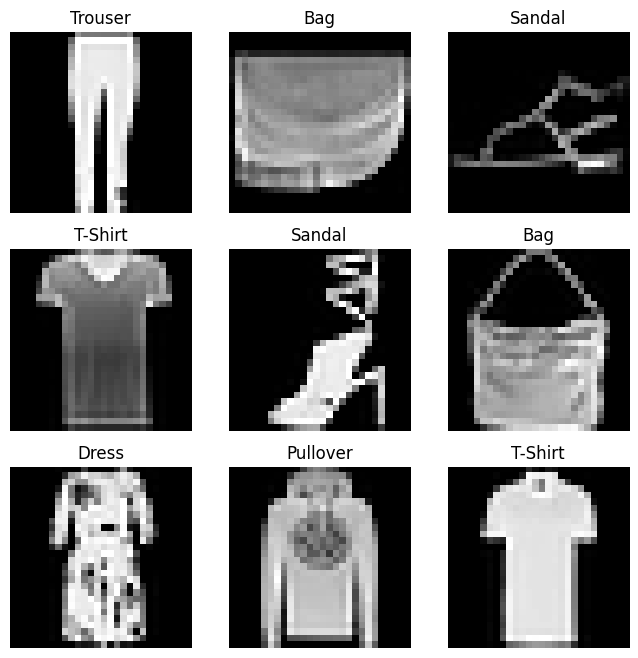

In [ ]:
figure = plt.figure(figsize = (8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # training data 중 무작위 인덱스 선택
  img, label = training_data[sample_idx] # 선택된 이미지와 그에 해당하는 정답라벨
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray') # 채널을 (1,28,28) 에서 (28,28)로 축소
plt.show()

# Creating a Custom Dataset for your files

커스텀 dataset class를 만들려면 3가지 메서드를 반드시 구현해야됨
```
__init__(self, ...)
__len__(self)
__getitem__(self, idx)
```


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

# 커스텀 데이터셋 클래스 생성
# DataLoader에 넣을 수 있는 표준 형식이 되는거임
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file) # 라벨의 csv 읽어옴
    self.img_dir = img_dir # 이미지 폴더 경로 저장
    self.transform = transform # 이미지 전처리
    self.target_transform = target_transform # 라벨 전처리

  # 전체 샘플 개수를 반환
  def __len__(self):
    return len(self.img_labels) # len(dataset) 호출시 사용되는거임

  # 개별 샘플 가져오기
  # dataset[idx] 호출 시 작동하는거임
  # 특정 인덱스의 이미지와 라벨을 가져와서 전처리하고 튜플로 반환하는 형태
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0 ])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

# Preparing your data for training with DataLoaders

Dataset 객체는 한번에 하나의 샘플만 불러와줌

하지만 딥러닝 학습은 미니배치 단위로 데이터를 주는게 일반적

매 epoch마다 데이터를 다시 섞어주는 셔플도 필요함 -> 항상 같은 순서로 학습하면 모델이 과적합 될수도 있으니까

이미지나 텍스트를 여러 CPU 프로세스로 병렬 처리하면 데이터 로딩 속도도 훨씬 빨라짐

이런 복잡한 기능들을 가능케 하는게 DataLoader 인거임

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
ttest_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

# Iterate through the DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


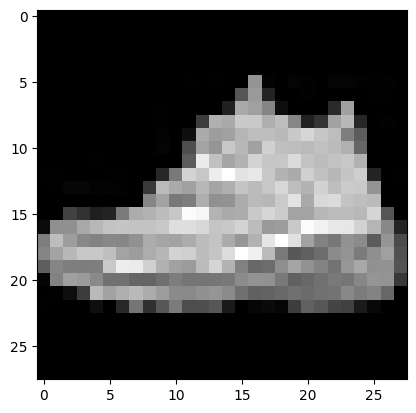

Label: 9


In [ ]:
# train_dataloader는 반복 가능한 객체, iterable임
# iter()로 iterator를 만들고 next()로 처음 한 배치만 가져옴 (여기선 배치사이즈 64만큼을 가져옴)
train_features, train_labels = next(iter(train_dataloader))

# 배치의 크기를 보면 64인것을 확인할 수 있음
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# 첫번째 이미지만 시각화 해보자
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")